## Gender Classification

### Model - PCA and SVM

### Input - Images

In [24]:
import dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import os

Run the below lines to get shape_predictor_68_face_landmarks.dat

In [2]:
# ! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# ! bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

Loading custom dataset

In [3]:
with open('custom_dataset.pkl', 'rb') as f:
    loaded_df = pickle.load(f)

Reshaping flattened image data back to 512x512 matrix

In [4]:
loaded_df['image_front_data'] = loaded_df['image_front_data'].apply(lambda x: np.array(x).reshape(512, 512))
loaded_df['image_side_data'] = loaded_df['image_side_data'].apply(lambda x: np.array(x).reshape(512, 512))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7663 entries, 0 to 7662
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7663 non-null   object 
 1   sex               7662 non-null   object 
 2   bmi               7641 non-null   float64
 3   image_front_data  7663 non-null   object 
 4   image_side_data   7663 non-null   object 
dtypes: float64(1), object(4)
memory usage: 299.5+ KB


Loading face detector and landmark predictor

In [5]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

Extracting feature points from the images

In [6]:
temp = pd.DataFrame()
labels = []
for i in range(len(loaded_df)):
    image = loaded_df['image_front_data'].iloc[i]
    faces = detector(image)
    
    if not faces:
        print('No face detected :',loaded_df['id'].iloc[i])
        continue

    landmarks = predictor(image, faces[0])

    if not landmarks:
        print('No landmarks detected :',loaded_df['id'].iloc[i])
        continue
        
    feature = []
    for coord in range(68):
        x_coord = landmarks.part(coord).x
        y_coord = landmarks.part(coord).y
        feature.append(x_coord)
        feature.append(y_coord)
        
    temp = pd.concat([temp, pd.DataFrame([feature])], ignore_index=True)
    if(loaded_df['sex'].iloc[i] == 'Male'):
        labels.append(0)
    else:
        labels.append(1)

No face detected : A01950
No face detected : A02376
No face detected : A10508
No face detected : A10913
No face detected : A10938
No face detected : A15580
No face detected : A50324
No face detected : A60145
No face detected : A61010
No face detected : A63742
No face detected : A68718
No face detected : A70170
No face detected : A70208
No face detected : A71429
No face detected : A73555
No face detected : A74143
No face detected : A80442
No face detected : A80582
No face detected : A82092
No face detected : A83084
No face detected : A83405
No face detected : A83673
No face detected : A87924
No face detected : A90240
No face detected : A90485
No face detected : A90911
No face detected : A91250
No face detected : A91584
No face detected : A92280
No face detected : A92800
No face detected : A95046
No face detected : A97884
No face detected : B00659
No face detected : B03186
No face detected : B03191
No face detected : B04516
No face detected : B04938
No face detected : B04962
No face dete

Number of males and females

In [7]:
labels.count(0), labels.count(1)

(3915, 3662)

Applying PCA to capture 99.9% variance

In [8]:
def PCA(dataset):
    mean = np.mean(dataset, axis=0)
    z = dataset - mean
    cov_matrix = (1/len(dataset)) * (z.T).dot(z)
    eig_values, eig_vectors = np.linalg.eig(cov_matrix)
    eig_pairs = [(eig_values[i], eig_vectors[:,i]) for i in range(len(eig_values))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)

    sorted_eigvalues = [eig_pairs[i][0] for i in range(len(eig_values))]
    sorted_eigvectors = np.array([eig_pairs[i][1] for i in range(len(eig_values))])

    cumulative_variance = np.cumsum(sorted_eigvalues) / np.sum(sorted_eigvalues)
    plt.plot(cumulative_variance)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance')
    plt.title('Cumulative Variance vs Number of Principal Components')
    plt.show()

    n_components = np.argmax(cumulative_variance > 0.999) + 1

    print('Number of Principal Components required:', n_components)

    W = sorted_eigvectors[:, :n_components]
    print('Shape of W:', W.shape)

    dataset_pca = z.dot(W)
    print('Shape of Reduced Dataset:', dataset_pca.shape)
    return W, dataset_pca, mean

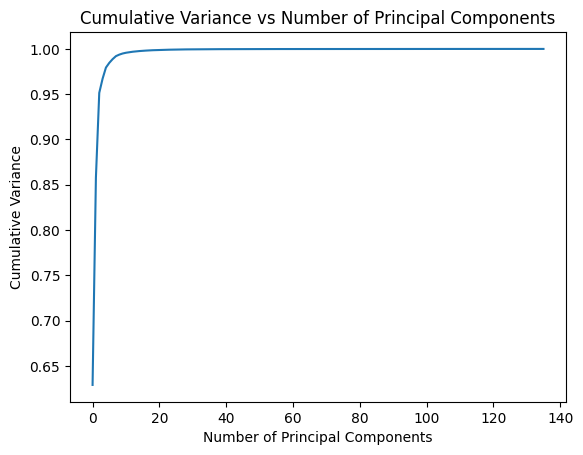

Number of Principal Components required: 23
Shape of W: (136, 23)
Shape of Reduced Dataset: (7577, 23)


In [9]:
W, dataset_reduced, mean = PCA(np.array(temp))

Perform SVM on the reduced dataset and labels

In [36]:
X_train, X_test, y_train, y_test = train_test_split(dataset_reduced, labels, test_size=0.1, random_state=42)

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9155672823218998


Calculating MAE, MSE, R2 and Pearson Coefficient 

In [41]:
def mean_absolute_error(y_true, y_pred):
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(len(y_true))) / len(y_true)
    return mae

def mean_squared_error(y_true, y_pred):
    mse = sum((y_true[i] - y_pred[i])**2 for i in range(len(y_true))) / len(y_true)
    return mse

def r2_score(y_true, y_pred):
    mean_y_true = sum(y_true) / len(y_true)
    ss_total = sum((y - mean_y_true)**2 for y in y_true)
    ss_residual = sum((y_true[i] - y_pred[i])**2 for i in range(len(y_true)))
    r2 = 1 - (ss_residual / ss_total)
    return r2

def pearson_correlation(y_true, y_pred):
    mean_y_true = sum(y_true) / len(y_true)
    mean_y_pred = sum(y_pred) / len(y_pred)
    numerator = sum((y_true[i] - mean_y_true) * (y_pred[i] - mean_y_pred) for i in range(len(y_true)))
    denominator = (
        (sum((y - mean_y_true)**2 for y in y_true)**0.5) * 
        (sum((y - mean_y_pred)**2 for y in y_pred)**0.5)
    )
    pearson_corr = numerator / denominator
    return pearson_corr

NameError: name 'train_test_split' is not defined

In [42]:
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test[:200], y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test[:200], y_pred))
print("R2 Score:", r2_score(y_test[:200], y_pred))
print("Pearson Correlation Coefficient:", pearson_correlation(y_test[:200], y_pred))

Mean Absolute Error (MAE): 0.09
Mean Squared Error (MSE): 0.09
R2 Score: 0.6396757081373237
Pearson Correlation Coefficient: 0.4203371949175812


Predicting on new images

In [43]:
def predict(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (512, 512))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()
    
    faces = detector(gray)
    landmarks = predictor(gray, faces[0])

    feature = []
    for coord in range(68):
        x_coord = landmarks.part(coord).x
        y_coord = landmarks.part(coord).y
        feature.append(x_coord)
        feature.append(y_coord)

    feature = np.array(feature).reshape(1, -1)
    feature = feature - mean
    feature_pca = feature.dot(W)

    prediction = clf.predict(feature_pca)
    if prediction == 0:
        return 'Male'
    else:
        return 'Female'

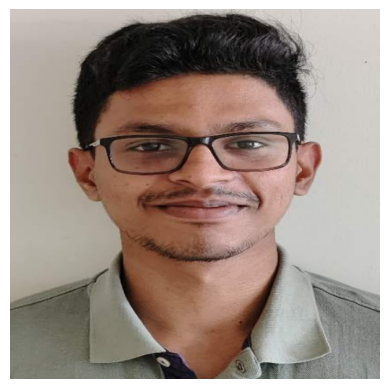

Predition for Image2.jpg : Male


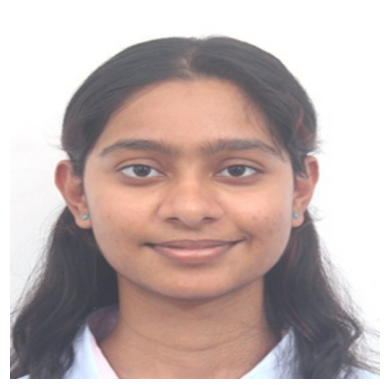

Predition for Image1.jpg : Female


In [44]:
image_folder = "test_images"
for filename in os.listdir(image_folder):    
    if filename.endswith(".jpg") or filename.endswith(".png"):
        file_path = os.path.join(image_folder, filename)
        
        print(f'Predition for {filename} : {predict(file_path)}')